# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort=False)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

<ipython-input-2-630d40a9059d>:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  survey = pd.concat([all_survey, d75_survey], axis=0)


# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

## Set Up Matplotlib

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

## Bar Plot of Correlations Between the Survey Fields and SAT Scores

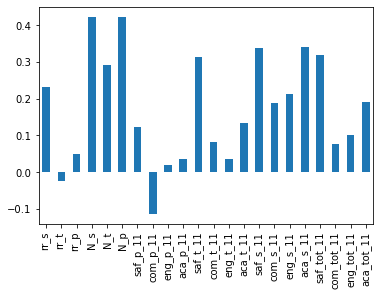

In [12]:
correlations[survey_fields].plot.bar()

# Safety Scores and SAT Scores

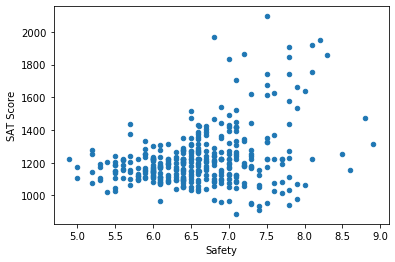

In [13]:
combined.plot.scatter(x="saf_s_11", y="sat_score")
plt.xlabel("Safety")
plt.ylabel("SAT Score")
plt.show()

Analysis...

# Map of Safety Scores for Each District

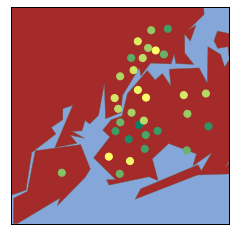

In [30]:
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").aggregate(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection = "merc",
    llcrnrlat = 40.496044,
    urcrnrlat = 40.915256,
    llcrnrlon = -74.255735,
    urcrnrlon = -73.700272,
    resolution = "i"
)

m.drawmapboundary(fill_color="#85A6D9")
m.drawcoastlines(color="#6D5F47", linewidth=0.4)
m.drawrivers(color="#6D5F47", linewidth=0.4)
m.fillcontinents(color="brown", lake_color="#85A6D9")

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(
    longitudes, 
    latitudes, 
    s=50, 
    zorder=2, 
    latlon=True,
    c=districts["saf_s_11"],
    cmap="summer"
)
plt.show()

conclusions about safety map

# Racial Differences in SAT Performance

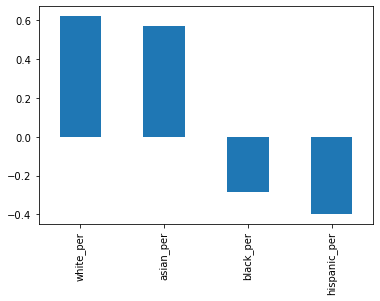

In [32]:
ethnicity_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][ethnicity_fields].plot.bar()

It seems there is a negative correlation between African American and Hispanic students and SAT scores.  Meaning that Hispanics and African American students tend to do worse than Asian and Caucasian students.

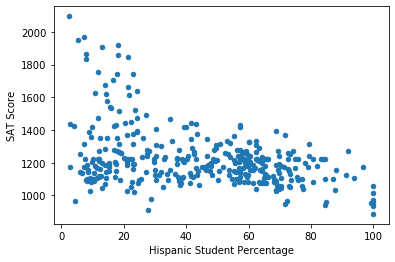

In [34]:
combined.plot.scatter(x="hispanic_per", y="sat_score")
plt.xlabel("Hispanic Student Percentage")
plt.ylabel("SAT Score")
plt.show()

In [41]:
high_pct_hispanic = combined[combined["hispanic_per"] > 95].sort_values(by="hispanic_per", ascending=False)
print(high_pct_hispanic["SCHOOL NAME"])

286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
44                         MANHATTAN BRIDGES HIGH SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
Name: SCHOOL NAME, dtype: object


Seems these schools are geared towards international students who are still learning English, which would explain the low SAT scores.

In [43]:
low_pct_hisp_high_sat = combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]
print(low_pct_hisp_high_sat["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools with high SAT scores have a tendency to focus on math and science ciriculum.

# Gender Differences Between SAT Scores

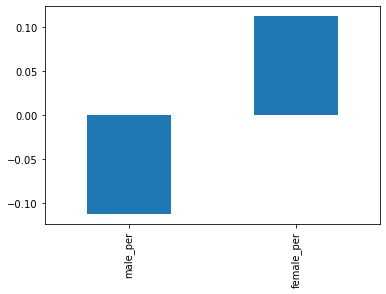

In [44]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

insights?

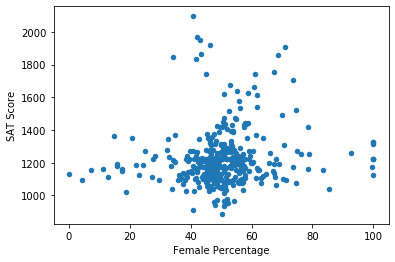

In [45]:
combined.plot.scatter(x="female_per", y="sat_score")
plt.xlabel("Female Percentage")
plt.ylabel("SAT Score")
plt.show()

In [46]:
high_female_high_sat = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]
print(high_female_high_sat["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appear to be liberal arts schools that have high academic standards.

# Correlation of Advanced Placement Exams and SAT Scores

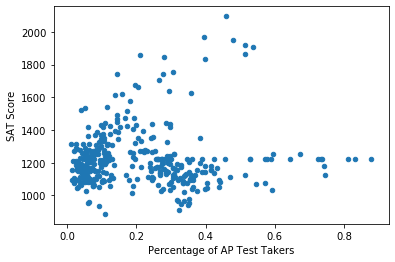

In [47]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter(x="ap_per", y="sat_score")
plt.xlabel("Percentage of AP Test Takers")
plt.ylabel("SAT Score")
plt.show()